In [1]:
import pickle
import pandas as pd
from CITEsort.BTreeTraversal import BTreeTraversal
from CITEsort.Visualize import plot_keymarker,visualize_tree
import matplotlib
#import numpy as np
from matplotlib import pyplot as plt

## load data and tree 

In [32]:
# data = pd.read_csv('datasets/SeuratV4/adt_main_clr.csv',header=0,index_col=0)

# data = pd.read_csv('./datasets/SeuratV4/adt_p8_main_clr.csv',header=0,index_col=0)
id ='5_4'
# data = pd.read_csv('../simulator_out/ADT_simulator_'+id+'.csv',index_col=0)
data = pd.read_csv('../SeuratV3/subdata/'+id+'_ADT.csv', sep=',',index_col=0, header=0)
# data.index = data.index.astype(str)
# id='3_2_'
f = open('../output/'+id+'/tree.pickle','rb')
# f = open('CITEsort_out/SeuratV3_main_ct_smooth2/tree.pickle','rb')
tree = pickle.load(f)
f.close()

In [33]:
traversal = BTreeTraversal(tree)

## plot compact tree or complete tree
#### The paramter '--compact' of runing runCITEsort.py will set the tree in compact format. If complete format is needed, plot tree again as below. The filename should no longer be 'tree', or the original tree.pdf will be overwritten.

In [ ]:
# visualize_tree(tree,data,outpath='./CITEsort_out',filename='tree_complete',compact=False)

In [4]:
import numpy as np
def smooth(x,item=0,num=6):
    if x.iloc[0,:].any() < 0:
    # i = [i for i in item][0]
    # print(i,value[:5])
    # print(value[0],value[1])
        x = x.apply(np.expm1)

    # print('before',(x.isnull()).any())
    for i in x.columns:
        value = np.unique(x.loc[:,i].values.tolist())
        num = min(len(value),num)
        x.loc[:,i] += np.random.normal(loc=0, scale=1,size=x.shape[0]) * 0.01
        # for k in range(num-1):
        #     # print(x.loc[x.loc[:,i]==value[k],i])
        #     x.loc[x.loc[:,i]==value[k],i] += np.random.normal(loc=0, scale=1, size=sum(x.loc[:,i]==value[k])) * (value[k+1]-value[k])*0.1
        # print(i,':',len(value))

    y = np.apply_along_axis(lambda x: np.log(x+1) - np.mean(np.log(x+1)),0,x)
    x = pd.DataFrame(y, index=x.index, columns=x.columns)
    x.mask(x.isnull(),0)
    # print('after',(x.isnull()).any())
    return x


In [24]:
data_ = smooth(data)

## visualize all markers in a certain node
#### the node ID is just the number before the node name in tree.pdf

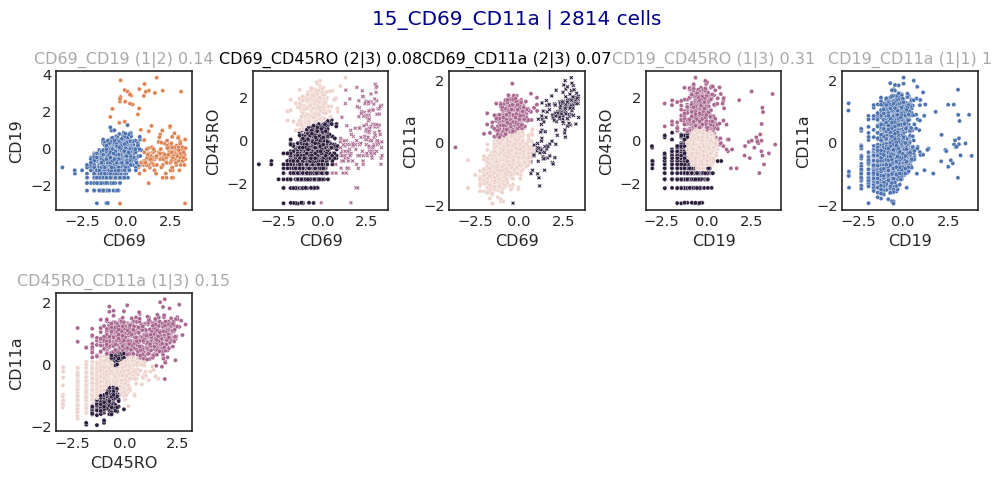

In [29]:
node_ID = 15

traversal.plot_node(data_,node_ID,viz_dim=2)

In [31]:
node = traversal.get_node(15)
node.all_clustering_dic[2][('CD69', 'CD19')]
# len(node.indices)
node.score_dict

{('CD69', 'CD45RO'): 0.5394016278212295, ('CD69', 'CD11a'): 0.5409976949277207}

In [88]:
from scipy.stats import multivariate_normal, norm
def assign_GMM(sample, mean_list, cov_list, weight, if_log=False, marker_list=None, confidence_threshold=0, throw=True):
    """confidence_threshold is used to not assign dots with low confidence to each group:
        a big confidence_threshold represents a more strict standard for confidential dots"""
    confidence_threshold = (1-confidence_threshold) / len(weight) * 2
    index = sample.index
    # sample = np.array(sample)
    weight = np.array(weight)
    if if_log:
        type_num = np.log(weight/sum(weight))
    else:
        type_num = weight/sum(weight)
    
    p_prior = np.zeros(shape=(len(sample),len(weight)))
    for i in range(len(weight)):
        if if_log:
            # print('sample_null',sample.loc[:,marker_list].isnull().any().any(), 'mean_null', mean_list[i][marker_list].isnull().any().any(), 'cov_null', cov_list[i].loc[marker_list,marker_list].isnull().any().any())
            # print('marker len:',marker_list[i].shape[0])
            p_prior[:,i] = multivariate_normal.logpdf(np.array(sample.loc[:,marker_list]), mean=np.array(mean_list[i][marker_list]), cov=np.array(cov_list[i].loc[marker_list,marker_list]),allow_singular=True)
            p_prior[:,i] = p_prior[:,i] + type_num[i]
            
        else:
            p_prior[:,i] = multivariate_normal.pdf(np.array(sample.loc[:,marker_list]), mean=np.array(mean_list[i][marker_list]), cov=np.array(cov_list[i].loc[marker_list,marker_list]),allow_singular=True)   
            p_prior[:,i] = p_prior[:,i] * type_num[i]
    # p_prior = -p_prior 
    
    p_post = p_prior / (p_prior.sum(axis=1)[:,np.newaxis] )
    pred_label = np.argmin(p_post,axis=1)
    if throw:
        pred_label = [pred_label[i] if p_post[i,pred_label[i]]<confidence_threshold else -1 for i in range(len(pred_label)) ]
        print('throw')
    # print(p_post[:10,:])
    # print(pred_label[:10])
    pred_label = pd.Series(data=pred_label,index=index)    
    return pred_label

In [103]:
leaf_list = [node for node in traversal.nodelist if node.stop!=None]
marker_list = [node.marker[i] for node in leaf_list for i in range(len(node.marker))]
mean_list = [node.mean for node in leaf_list] 
cov_list = [node.cov for node in leaf_list]
w_list = [node.weight for node in leaf_list] 
marker_list = list(set(marker_list))
y = np.apply_along_axis(lambda x: np.log(x+1) - np.mean(np.log(x+1)),0,data)
x = pd.DataFrame(y, index=data.index, columns=data.columns)
new_label = assign_GMM(x, mean_list, cov_list, w_list, marker_list=marker_list, if_log=True, confidence_threshold=0, throw=False)
for i in range(len(leaf_list)):
    node = leaf_list[i]
    sub_data = data[new_label==i]
    node.indices = sub_data.index.tolist()

/tmp/ipykernel_2798123/1560725178.py:10: RuntimeWarning: divide by zero encountered in log
  type_num = np.log(weight/sum(weight))
/tmp/ipykernel_2798123/1560725178.py:27: RuntimeWarning: invalid value encountered in true_divide
  p_post = p_prior / (p_prior.sum(axis=1)[:,np.newaxis] )


In [104]:
label = pd.DataFrame({'GEM':data.index,'Label':[None]*len(data)},index=data.index)
for i in range(len(leaf_list)):
    if leaf_list[i].key == ('leaf',):
        label.loc[leaf_list[i].indices,'Label'] = str(leaf_list[i].ind)+'_'+'_'.join(leaf_list[i].key) 

In [105]:
label.to_csv('../output/3_2_/' + '/new_leaf_labels.csv')

In [101]:
ind = 0
def dfs(node,id):
    if node.key == ('leaf',):
        node.indices = leaf_list[i].indices
        if node.ind != leaf_list[i].ind:
            print(node.ind, leaf_list[i].ind)
        ind = ind +1
        return node       
    else:
        
        node.left = dfs(node.left,id)
        node.right = dfs(node.right,id)
        return node

new_tree = dfs(tree,0)

11 30


UnboundLocalError: local variable 'ind' referenced before assignment

In [26]:
def finetune_dfs(node, cutID, cut=False):
    
    if node.key == ('leaf',):
        if cut == True:
            node.key = ('cutleaf',)
        return node       
    else:
        if cut:
            node.key = ('cutleaf',)
        if node.ind in cutID:
            node.key = ('leaf',)
            cut = True
        
        print(node.ind)
        node.left = finetune_dfs(node.left, cutID, cut=cut)
        node.right = finetune_dfs(node.right, cutID, cut=cut)
        return node

In [34]:
newtree = finetune_dfs(tree, [11])

0
1
9
15
16
10
11
2
3
5
7
21
8
26


In [35]:
visualize_tree(newtree,data_,'../output/'+id,'/cuttree',compact=True)
    
f = open('../output/'+id+'/cuttree.pickle','wb')
pickle.dump(tree,f)
f.close()

newtravel = BTreeTraversal(newtree)
newleaf = newtravel.get_leaf_label()
leaves_labels = newtravel.get_leaf_label()
leaves_labels.to_csv('../output/' +id+ '/cut_leaf_labels.csv')

/home/xinzhu/Desktop/git-test/CITE-sortV2


In [10]:
newtravel.get_node(7).key

('cutleaf',)

In [ ]:
import diptest
diptest.dipstat(data.loc[node.indices,'CD8a'])
# len(data.loc[node.indices,'CD158'])

In [ ]:
traversal.plot_node_umap(data, nodeID=6)

In [ ]:
traversal.plot_node_2dim_new(data, 7, 'CD27', 'CD16')
# traversal.plot_node_2dim_new(data, 20, 'CD8a', 'CD4')
# traversal.plot_node_2dim_new(data, 2, 'CD4-1', 'CD19')

In [ ]:
score_ll = traversal.get_ll(4)
print('likelyhood gain:')
for key,value in score_ll.items():
    print(key,round(value,3))

## visualize the key marker in a certain node
#### the node ID is just the number before the node name in tree.pdf

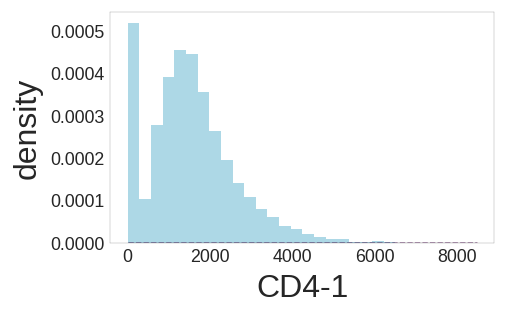

In [35]:
plot_keymarker(data,traversal,node_ID=1,dpi=128)

In [ ]:
from scipy.stats import multivariate_normal, norm
import numpy as np

def assign_GMM(sample, mean_list, cov_list, weight, if_log=False, marker_list=None):
    # print(cov_list)
    index = sample.index
    # sample = np.array(sample)
    weight = np.array(weight)
    if if_log:
        type_num = np.log(weight/sum(weight))
    else:
        type_num = weight/sum(weight)
    
    p_prior = np.zeros(shape=(len(sample),len(weight)))
    for i in range(len(weight)):
        if if_log:
            # print(i)
            p_prior[:,i] = multivariate_normal.logpdf(np.array(sample.loc[:,marker_list]), mean=np.array(mean_list[i][marker_list]), cov=np.array(cov_list[i].loc[marker_list,marker_list]),allow_singular=True)
            p_prior[:,i] = p_prior[:,i] + type_num[i]
            
        else:
            
            # print([cov_list[i][j,j] for j in range(len(cov_list[i]))])
            # print(sample.loc[:,marker_list[i]])
            # print(mean_list[i])
            # print(cov_list[i])
            p_prior[:,i] = multivariate_normal.pdf(np.array(sample.loc[:,marker_list[i]]), mean=np.array(mean_list[i]), cov=np.array(cov_list[i]))   
            p_prior[:,i] = p_prior[:,i] * type_num[i]
    # p_prior = -p_prior 
    
    p_post = p_prior / (p_prior.sum(axis=1)[:,np.newaxis] )
    pred_label = np.argmin(p_post,axis=1)
    # print(p_prior[:10,:])
    # print(pred_label[:10])
    pred_label = pd.Series(data=pred_label,index=index)
    return pred_label

In [ ]:
leaf_list = traversal.nodelist.copy()
leaf_list.pop(0)
leaf_list.pop(0)
leaf_list.pop(1)

In [ ]:
node = traversal.get_node(3)
mean_list = [node.mean for node in leaf_list] 
cov_list = [node.cov for node in leaf_list]
w_list = [node.weight for node in leaf_list]
simulator = pd.read_csv('../simulator/ADT_simulator_9_10.csv', sep=',', index_col=0, header=0)
raw_label = assign_GMM(simulator, mean_list, cov_list, w_list, if_log=True,marker_list=['CD4-1','CD19','CD16','CD8'])
add_label = assign_GMM(simulator, mean_list, cov_list, w_list, if_log=True,marker_list=['CD4-1','CD19','CD16','CD8','CD3-1'])
#### 尝试用所有cutof<0.5的feature来assign，相当于是一个高维的gate

In [ ]:
import umap
import umap.plot
import matplotlib.pyplot as plt

mapper = umap.UMAP().fit(simulator)
umap.plot.points(mapper, labels=raw_label)
umap.plot.points(mapper, labels=add_label)

In [ ]:
raw_label.iloc[20675:].value_counts()
# add_label.iloc[20675:].value_counts()

In [ ]:
# add_label.index = simulator.index
simulator[raw_label==3].to_csv('../simulator/ADT_simulator_9_11.csv')

In [ ]:
from CITEsort.Visualize import visualize_2dim

visualize_2dim(simulator[raw_label==3]['CD3-1'],simulator[raw_label==3]['CD8'],raw_label[raw_label==3])
visualize_2dim(simulator[add_label==3]['CD3-1'],simulator[add_label==3]['CD8'],add_label[add_label==3])

In [ ]:
keys = []
for i in range(28):
    node = traversal.get_node(i)
    if list(node.key) != 'leaf':
        print(node.key)

In [ ]:
'IgD',
'CD26-1',
'CD72',
'CD4-1',
'CD27', 'CD8a
'CD8a',
'CD244',
'CD4-1',
'CD27',
'CD244',
'CD158', 'CD21',
'CD3-1'